In [31]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from IPython.display import display, clear_output


In [32]:
# Leitura do dataset
df = pd.read_csv('custos_medicos_20000_realista_completo_v2.csv')

In [33]:
# Análise inicial
print(df.head())
print(df.info())
print(df.describe())

   idade     genero    imc  filhos fumante    regiao estado  \
0     56  masculino  25.18       1     não  nordeste     PE   
1     46  masculino  33.65       1     não  nordeste     BA   
2     32  masculino  33.83       2     não  nordeste     MA   
3     60   feminino  23.59       1     sim   sudeste     RJ   
4     25  masculino  27.45       2     não       sul     PR   

  historico_diabetes historico_hipertensao historico_doenca_cardiaca  \
0                não                   não                       não   
1                sim                   não                       não   
2                não                   sim                       não   
3                não                   não                       não   
4                não                   não                       sim   

  historico_cancer historico_colesterol_alto faz_academia  \
0              não                       não          não   
1              não                       não          não   
2    

In [34]:
# Verificação de valores ausentes
print("\nValores ausentes por coluna:\n", df.isnull().sum())


Valores ausentes por coluna:
 idade                        0
genero                       0
imc                          0
filhos                       0
fumante                      0
regiao                       0
estado                       0
historico_diabetes           0
historico_hipertensao        0
historico_doenca_cardiaca    0
historico_cancer             0
historico_colesterol_alto    0
faz_academia                 0
frequencia_academia          0
atividade_fisica_moderada    0
profissao                    0
renda_mensal                 0
tipo_plano                   0
encargos                     0
dtype: int64


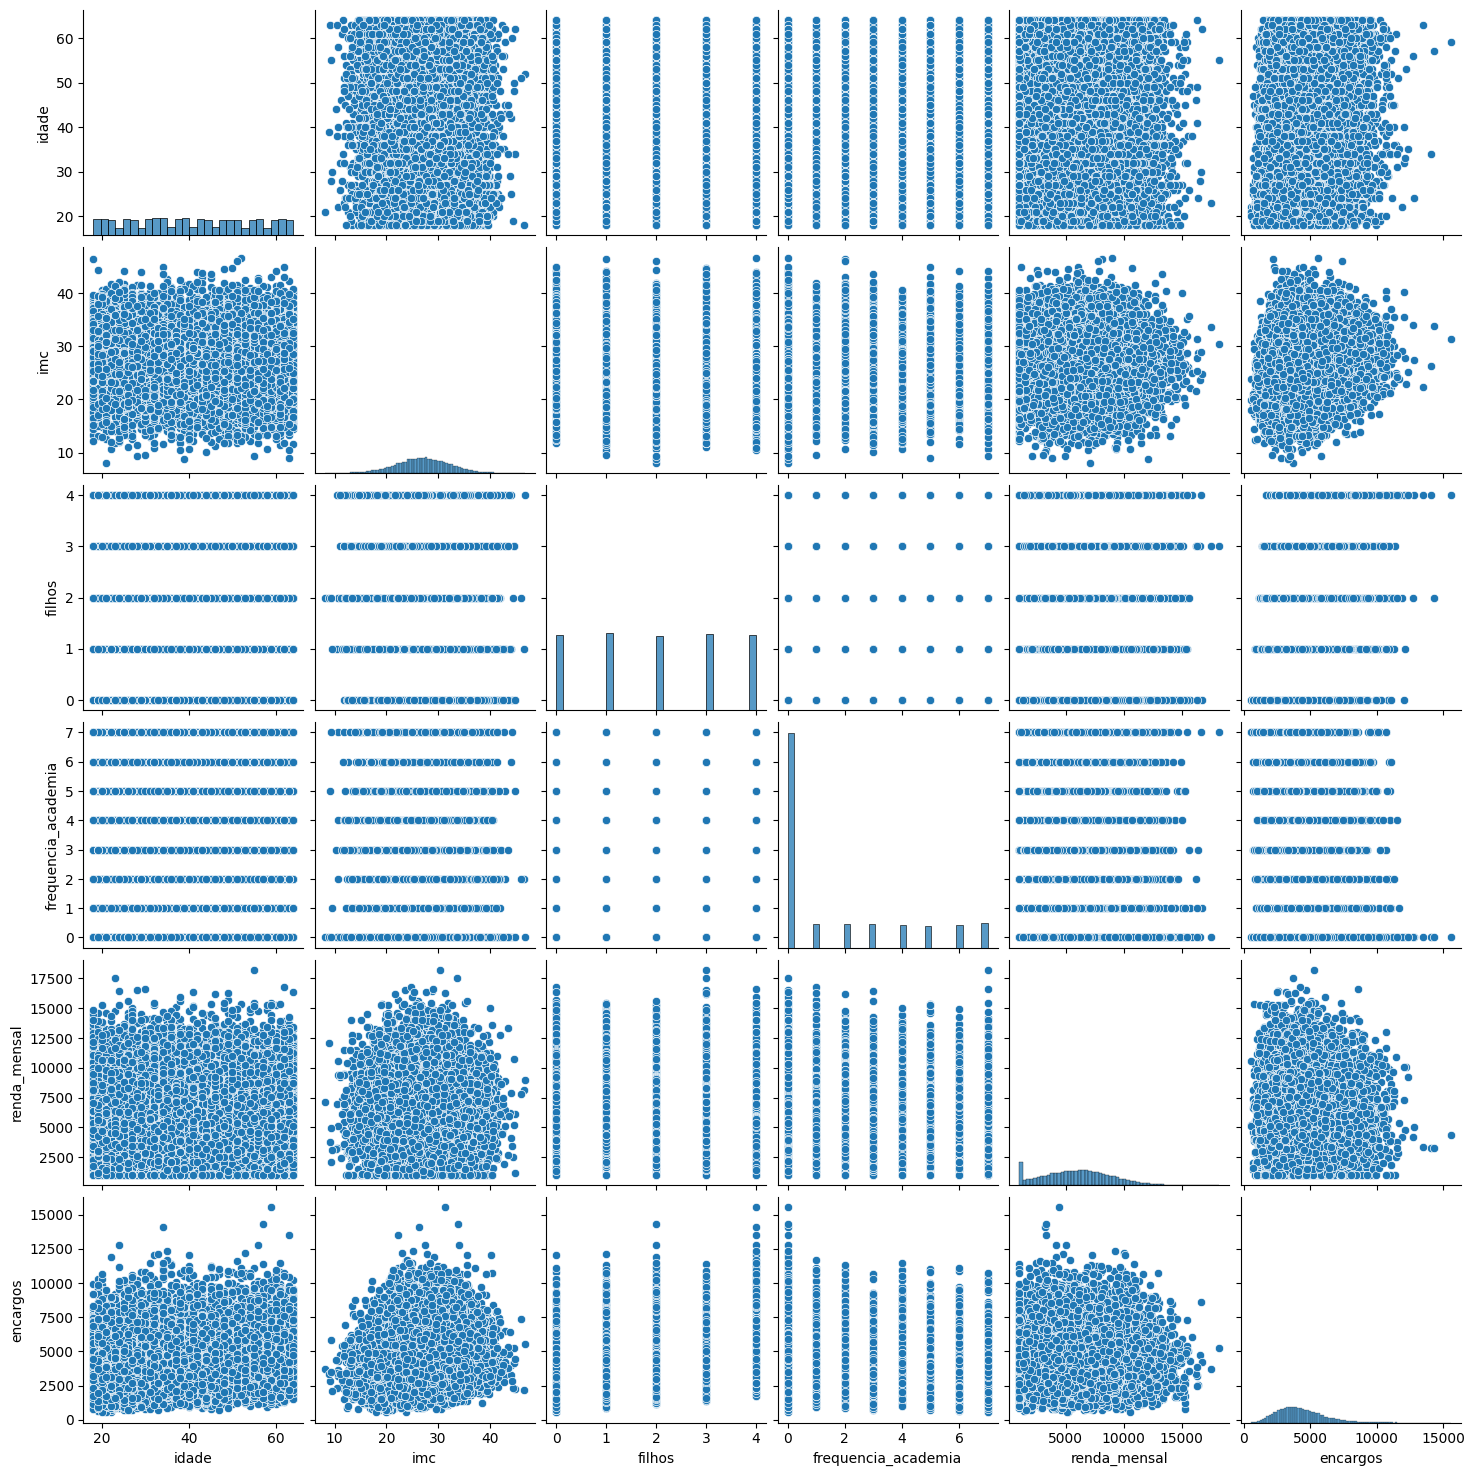

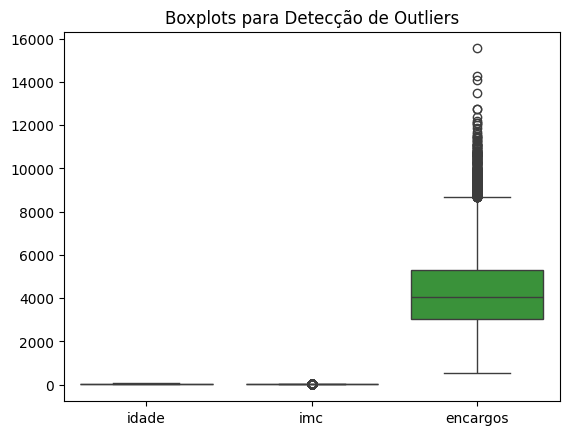

In [35]:
# Visualizações iniciais
sns.pairplot(df)
plt.show()

sns.boxplot(data=df[['idade', 'imc', 'encargos']])
plt.title('Boxplots para Detecção de Outliers')
plt.show()

In [36]:
# Winsorização da coluna encargos
df['encargos'] = winsorize(df['encargos'], limits=[0.01, 0.01])

# One-hot encoding para variáveis categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Separar variáveis independentes e dependente
X = df_encoded.drop('encargos', axis=1)
y = df_encoded['encargos']

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelos
modelos = {
    "Regressão Linear": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}


In [37]:
# Avaliação dos modelos + cálculo da acurácia (erro ≤ 10%)
resultados = []

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    erro_percentual = np.abs((y_test - y_pred) / y_test) * 100
    acuracia_10 = np.mean(erro_percentual <= 10) * 100

    resultados.append([nome, rmse, mae, r2, acuracia_10])

    print(f"\n--- {nome} ---")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    print(f"Acurácia (erro ≤ 10%): {acuracia_10:.2f}%")


--- Regressão Linear ---
RMSE: 337.299996103527
MAE: 256.88960482041057
R²: 0.9608635395019394
Acurácia (erro ≤ 10%): 79.23%

--- Ridge Regression ---
RMSE: 337.3081155700744
MAE: 256.88738139504045
R²: 0.9608616552979068
Acurácia (erro ≤ 10%): 79.23%

--- Random Forest ---
RMSE: 349.11797519586713
MAE: 262.5321874833334
R²: 0.9580730477971147
Acurácia (erro ≤ 10%): 79.20%


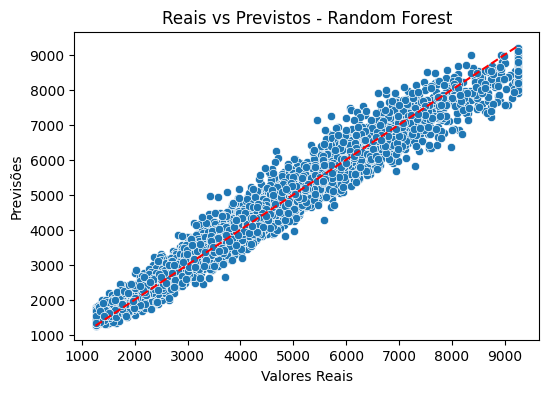

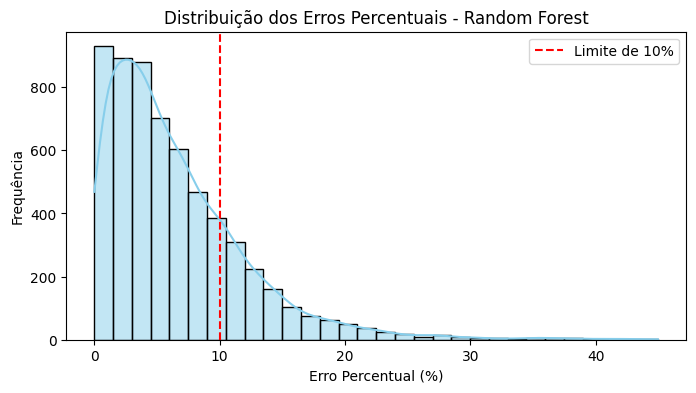

In [38]:
    # Gráfico de Previsão vs Real
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Valores Reais")
    plt.ylabel("Previsões")
    plt.title(f"Reais vs Previstos - {nome}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.show()



    # Gráfico da distribuição dos erros (somente para Random Forest)
    if nome == "Random Forest":
        plt.figure(figsize=(8, 4))
        sns.histplot(erro_percentual, bins=30, kde=True, color='skyblue')
        plt.axvline(10, color='red', linestyle='--', label='Limite de 10%')
        plt.title(f'Distribuição dos Erros Percentuais - {nome}')
        plt.xlabel('Erro Percentual (%)')
        plt.ylabel('Frequência')
        plt.legend()
        plt.show()


In [39]:
# Comparação final entre os modelos
df_resultados = pd.DataFrame(resultados, columns=['Modelo', 'RMSE', 'MAE', 'R²', 'Acurácia (≤10%)'])
print("\nComparação entre modelos:")
print(df_resultados.sort_values(by='Acurácia (≤10%)', ascending=False))


Comparação entre modelos:
             Modelo        RMSE         MAE        R²  Acurácia (≤10%)
0  Regressão Linear  337.299996  256.889605  0.960864        79.233333
1  Ridge Regression  337.308116  256.887381  0.960862        79.233333
2     Random Forest  349.117975  262.532187  0.958073        79.200000


In [40]:
# Modelo OLS para validações estatísticas
X_const = sm.add_constant(X_scaled)
ols_model = sm.OLS(y, X_const).fit()
print("\nResumo do modelo OLS:")
print(ols_model.summary())



Resumo do modelo OLS:
                            OLS Regression Results                            
Dep. Variable:               encargos   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 1.115e+04
Date:                Fri, 30 May 2025   Prob (F-statistic):               0.00
Time:                        16:03:47   Log-Likelihood:            -1.4468e+05
No. Observations:               20000   AIC:                         2.895e+05
Df Residuals:                   19955   BIC:                         2.898e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4263.7894      2.

In [41]:
# Teste de Heterocedasticidade - Breusch-Pagan
residuos = ols_model.resid
_, pval, _, f_pval = het_breuschpagan(residuos, X_const)
print("\nBreusch-Pagan p-value:", pval)



Breusch-Pagan p-value: 0.0


In [42]:
# Verificação de Multicolinearidade com VIF
vif_data = pd.DataFrame()
vif_data["Variável"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print("\nVIF por variável:")
print(vif_data)

c:\Users\Gustavo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF por variável:
                             Variável       VIF
0                               idade  1.001972
1                                 imc  1.002237
2                              filhos  1.001798
3                 frequencia_academia  7.557161
4                        renda_mensal  1.002272
5                    genero_masculino  1.002161
6                         fumante_sim  1.002058
7                     regiao_nordeste       inf
8                        regiao_norte       inf
9                      regiao_sudeste       inf
10                         regiao_sul       inf
11                          estado_BA       inf
12                          estado_CE       inf
13                          estado_DF       inf
14                          estado_ES       inf
15                          estado_GO       inf
16                          estado_MA       inf
17                          estado_MG       inf
18                          estado_MS       inf
19                   

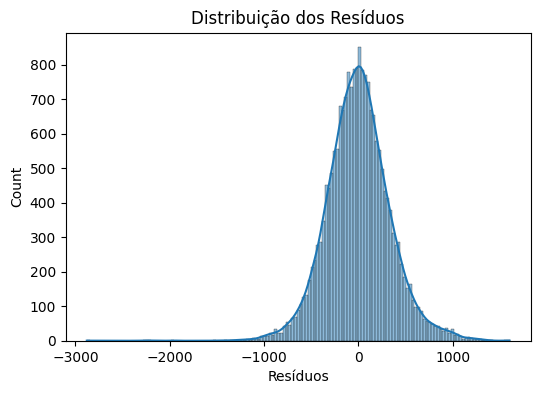

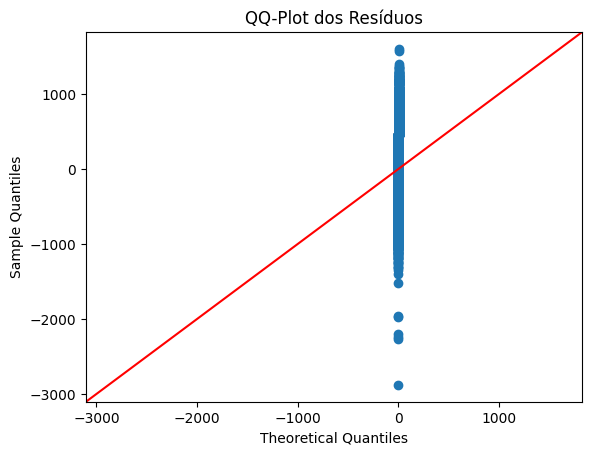

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13028\2577754173.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:20], y=nomes_variaveis[indices][:20], palette='viridis')


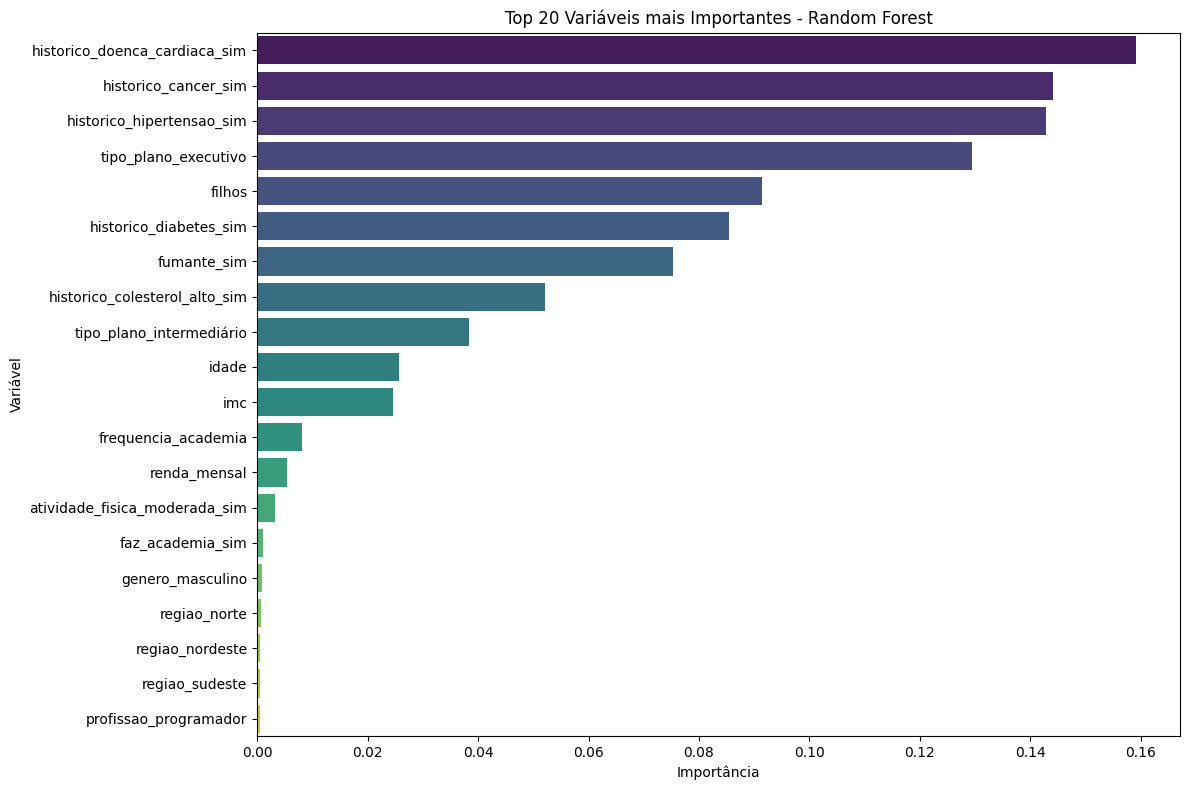

In [43]:
# Análise dos resíduos
plt.figure(figsize=(6, 4))
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduos")
plt.show()

# QQ-Plot dos resíduos
sm.qqplot(residuos, line='45')
plt.title("QQ-Plot dos Resíduos")
plt.show()

# Pega os nomes das colunas (variáveis)
nomes_variaveis = X.columns


# Get feature importances from the trained Random Forest model
importances = modelos['Random Forest'].feature_importances_

# Sort importances and get the indices
indices = np.argsort(importances)[::-1]

# Plot do gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices][:20], y=nomes_variaveis[indices][:20], palette='viridis')
plt.title('Top 20 Variáveis mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

In [44]:
# Dicionário de estados por região
estados_por_regiao = {
    'norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
    'nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'centro-oeste': ['DF', 'GO', 'MT', 'MS'],
    'sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'sul': ['PR', 'RS', 'SC']
}

In [45]:
# Widgets com layout ajustado
idade = widgets.IntSlider(description='Idade', min=0, max=100, value=30)
genero = widgets.Dropdown(description='Gênero', options=['masculino', 'feminino'])

imc = widgets.FloatSlider(description='IMC', min=10, max=50, step=0.1, value=25)
filhos = widgets.IntSlider(description='Filhos', min=0, max=10, value=0)
fumante = widgets.Dropdown(description='Fumante', options=['nao', 'sim'])

regiao = widgets.Dropdown(description='Região', options=list(estados_por_regiao.keys()))
estado = widgets.Dropdown(description='Estado', options=estados_por_regiao['norte'])

historico_diabetes = widgets.Dropdown(description='Diabetes', options=['nao', 'sim'])
historico_hipertensao = widgets.Dropdown(description='Hipertensão', options=['nao', 'sim'])
historico_doenca_cardiaca = widgets.Dropdown(description='Cardíaca', options=['nao', 'sim'])
historico_cancer = widgets.Dropdown(description='Câncer', options=['nao', 'sim'])
historico_colesterol_alto = widgets.Dropdown(description='Colesterol', options=['nao', 'sim'])

faz_academia = widgets.Dropdown(description='Academia', options=['nao', 'sim'])

frequencia_academia = widgets.IntSlider(
    description='Freq. semanal',
    min=0, max=7, value=3,
    layout=widgets.Layout(width='280px')
)

frequencia_academia = widgets.IntSlider(
    description='Freq. semanal',
    min=0, max=7, value=3,
    layout=widgets.Layout(width='280px'),
    style={'description_width': '100px'}
)

atividade_fisica_moderada = widgets.Dropdown(
    description='Ativ. moderada',
    options=['nao', 'sim'],
    layout=widgets.Layout(width='280px'),
    style={'description_width': '100px'}
)


# Profissão: dropdown com "outra" + campo texto
profissoes_comuns = [
    'auxiliar administrativo', 'engenheiro', 'estudante', 'motorista', 'médico',
    'operador de máquina', 'professor', 'programador', 'vendedor', 'outra'
]
profissao_dropdown = widgets.Dropdown(description='Profissão', options=profissoes_comuns)
profissao_custom = widgets.Text(description='(Outra)', placeholder='Digite aqui')

renda_mensal = widgets.FloatText(description='Renda (R$)', value=2500)
tipo_plano = widgets.Dropdown(description='Plano', options=['basico', 'intermediário', 'executivo'])

# Atualiza estados conforme a região
def atualizar_estados(change):
    nova_regiao = change['new']
    estado.options = estados_por_regiao[nova_regiao]

regiao.observe(atualizar_estados, names='value')

# Botão e saída
botao = widgets.Button(description="Prever Encargos", button_style='success')
saida = widgets.Output()

def ao_clicar_botao(b):
    profissao_final = (
        profissao_custom.value.lower() if profissao_dropdown.value == 'outra'
        else profissao_dropdown.value.lower()
    )

    dados = {
        'idade': idade.value,
        'genero': genero.value,
        'imc': imc.value,
        'filhos': filhos.value,
        'fumante': fumante.value,
        'regiao': regiao.value,
        'estado': estado.value,
        'historico_diabetes': historico_diabetes.value,
        'historico_hipertensao': historico_hipertensao.value,
        'historico_doenca_cardiaca': historico_doenca_cardiaca.value,
        'historico_cancer': historico_cancer.value,
        'historico_colesterol_alto': historico_colesterol_alto.value,
        'faz_academia': faz_academia.value,
        'frequencia_academia': frequencia_academia.value,
        'atividade_fisica_moderada': atividade_fisica_moderada.value,
        'profissao': profissao_final,
        'renda_mensal': renda_mensal.value,
        'tipo_plano': tipo_plano.value
    }

    df_input = pd.DataFrame([dados])
    df_completo = pd.concat([df.drop('encargos', axis=1), df_input], ignore_index=True)
    df_encoded = pd.get_dummies(df_completo, drop_first=True)
    df_encoded = df_encoded.reindex(columns=X.columns, fill_value=0)
    entrada_normalizada = scaler.transform([df_encoded.iloc[-1]])

    pred = modelos['Random Forest'].predict(entrada_normalizada)[0]
    mensal = pred / 12

    with saida:
        saida.clear_output()
        print(f"💰 Encargo **anual** previsto: R$ {pred:,.2f}")
        print(f"📆 Encargo **mensal** estimado: R$ {mensal:,.2f}")

botao.on_click(ao_clicar_botao)

# Layout em 3 colunas
coluna1 = widgets.VBox([idade, genero, imc, filhos, fumante, regiao, estado])
coluna2 = widgets.VBox([
    historico_diabetes, historico_hipertensao, historico_doenca_cardiaca,
    historico_cancer, historico_colesterol_alto,
    faz_academia, frequencia_academia, atividade_fisica_moderada
])
coluna3 = widgets.VBox([profissao_dropdown, profissao_custom, renda_mensal, tipo_plano, botao, saida])



# Exibir layout
display(widgets.HBox([coluna1, coluna2, coluna3], layout=widgets.Layout(gap='40px')))

